In [1]:
install.packages(c("tidymodels","modeltime","dplyr","timetk", "ggplot2", "glmnet", "tidyquant", "magrittr", "kknn"))

Installing packages into ‘/home/provak/R/x86_64-pc-linux-gnu-library/4.4’
(as ‘lib’ is unspecified)

also installing the dependencies ‘numDeriv’, ‘progressr’, ‘SQUAREM’, ‘diagram’, ‘lava’, ‘xfun’, ‘tzdb’, ‘prodlim’, ‘future.apply’, ‘listenv’, ‘lhs’, ‘V8’, ‘litedown’, ‘mvtnorm’, ‘pcaPP’, ‘DEoptimR’, ‘DiceDesign’, ‘sfd’, ‘sparsevctrs’, ‘patchwork’, ‘globals’, ‘clock’, ‘gower’, ‘ipred’, ‘furrr’, ‘doFuture’, ‘future’, ‘GPfit’, ‘modelenv’, ‘reactR’, ‘bigD’, ‘bitops’, ‘commonmark’, ‘fs’, ‘htmltools’, ‘htmlwidgets’, ‘juicyjuice’, ‘markdown’, ‘sass’, ‘snakecase’, ‘fracdiff’, ‘lmtest’, ‘tseries’, ‘urca’, ‘RcppArmadillo’, ‘dygraphs’, ‘extraDistr’, ‘rstantools’, ‘warp’, ‘RcppRoll’, ‘quadprog’, ‘pyinit’, ‘rrcov’, ‘robustbase’, ‘cpp11’, ‘broom’, ‘conflicted’, ‘dials’, ‘hardhat’, ‘infer’, ‘modeldata’, ‘parsnip’, ‘purrr’, ‘recipes’, ‘rsample’, ‘tune’, ‘workflows’, ‘workflowsets’, ‘yardstick’, ‘reactable’, ‘gt’, ‘janitor’, ‘parallelly’, ‘doParallel’, ‘forecast’, ‘xgboost’, ‘prophet’, ‘padr’, ‘xts’, ‘z

In [7]:
library(tidymodels)
library(dplyr)
library(timetk)
library(magrittr)
library(workflows)
library(parsnip)
library(recipes)
library(yardstick)
library(glmnet)
library(tidyverse)
library(tidyquant)
library(timetk)
library(kknn)
library(lubridate)

In [8]:
BC <- read.csv("BorderCrossingsFromUKR.csv") %>% 
    select(timeseries.data_date, timeseries.individuals) %>% 
    set_names(c("date","people"))

BC$date = as.Date(BC$date, format = '%Y-%m-%d')
BC

date,people
<date>,<int>
2022-02-24,4844
2022-02-25,6941
2022-02-26,11995
2022-02-27,15881
2022-02-28,13035
2022-03-01,12620
2022-03-02,12466
2022-03-03,11242
2022-03-04,10784


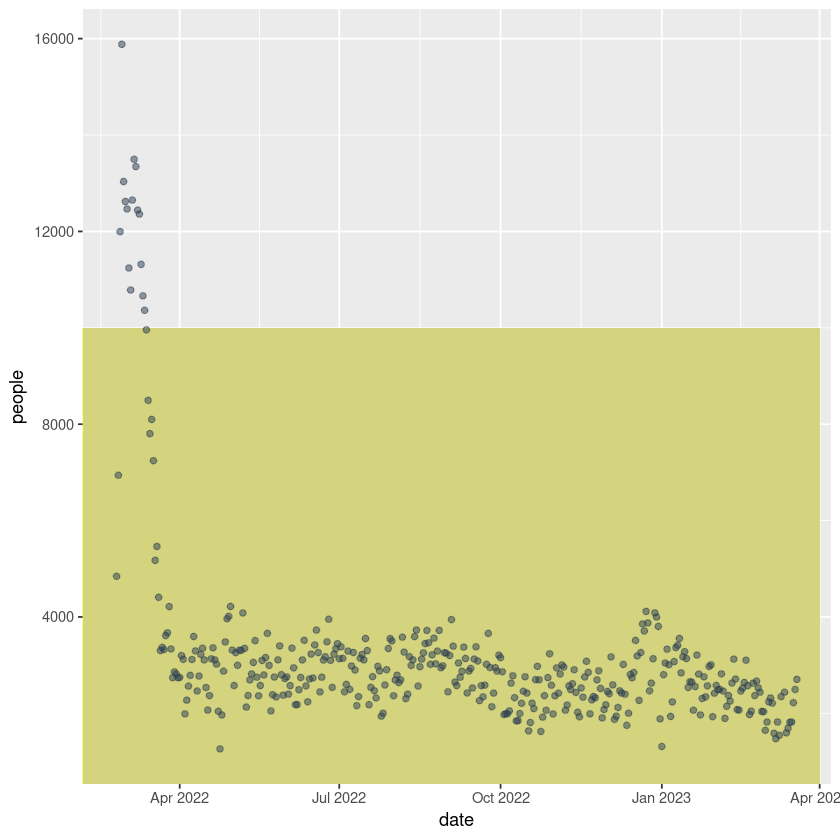

In [9]:
BC %>%
    ggplot(aes(x = date, y = people)) +
    geom_rect(xmin = as.numeric(ymd("2022-02-01")),
              xmax = as.numeric(ymd("2023-04-01")),
              ymin = 0, ymax = 10000,
              fill = palette_light()[[4]], alpha = 0.01) +
    geom_point(alpha = 0.5, color = palette_light()[[1]]) 

In [10]:
train_BC <- BC %>% 
    filter(date < ymd("2023-01-01") & date >= ymd("2022-04-01"))

test_BC <- BC %>% 
    filter(date >= ymd("2023-01-01"))

train_BC

date,people
<date>,<int>
2022-04-01,2747
2022-04-02,3199
2022-04-03,3121
2022-04-04,1991
2022-04-05,2274
2022-04-06,2566
2022-04-07,2789
2022-04-08,3118
2022-04-09,3595


In [11]:
# Add time series signature
recipe_spec_timeseries <- recipe(people ~ date, data = train_BC) %>%
    step_timeseries_signature(date) %>%   #adding time series signatures
    step_rm(date) %>%
    step_rm(contains("iso"), 
        contains("minute"), 
        contains("hour"),
        contains("am.pm"), 
        contains("xts")) %>%
    step_zv(date_year)%>%
    step_dummy(contains("lbl"), one_hot = TRUE) 

In [12]:
bake(prep(recipe_spec_timeseries), new_data = train_BC)

people,date_index.num,date_half,date_quarter,date_month,date_day,date_second,date_wday,date_mday,date_qday,⋯,date_month.lbl_10,date_month.lbl_11,date_month.lbl_12,date_wday.lbl_1,date_wday.lbl_2,date_wday.lbl_3,date_wday.lbl_4,date_wday.lbl_5,date_wday.lbl_6,date_wday.lbl_7
<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2747,1648771200,1,2,4,1,0,6,1,1,⋯,0,0,0,0,0,0,0,0,1,0
3199,1648857600,1,2,4,2,0,7,2,2,⋯,0,0,0,0,0,0,0,0,0,1
3121,1648944000,1,2,4,3,0,1,3,3,⋯,0,0,0,1,0,0,0,0,0,0
1991,1649030400,1,2,4,4,0,2,4,4,⋯,0,0,0,0,1,0,0,0,0,0
2274,1649116800,1,2,4,5,0,3,5,5,⋯,0,0,0,0,0,1,0,0,0,0
2566,1649203200,1,2,4,6,0,4,6,6,⋯,0,0,0,0,0,0,1,0,0,0
2789,1649289600,1,2,4,7,0,5,7,7,⋯,0,0,0,0,0,0,0,1,0,0
3118,1649376000,1,2,4,8,0,6,8,8,⋯,0,0,0,0,0,0,0,0,1,0
3595,1649462400,1,2,4,9,0,7,9,9,⋯,0,0,0,0,0,0,0,0,0,1


In [13]:
model_spec_glmnet <-  nearest_neighbor(neighbors = 3, weight_func = "gaussian") %>%
  # Using K-NN Regression
  set_mode("regression") %>%
  set_engine("kknn")

In [14]:
workflow_glmnet <- workflow() %>%
    add_recipe(recipe_spec_timeseries) %>%
    add_model(model_spec_glmnet)
    
workflow_glmnet

══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
5 Recipe Steps

• step_timeseries_signature()
• step_rm()
• step_rm()
• step_zv()
• step_dummy()

── Model ───────────────────────────────────────────────────────────────────────
K-Nearest Neighbor Model Specification (regression)

Main Arguments:
  neighbors = 3
  weight_func = gaussian

Computational engine: kknn 


In [15]:
workflow_trained <- workflow_glmnet %>% 
    fit(data = train_BC)

In [16]:
prediction_BC <- workflow_trained %>% 
    predict(test_BC) %>%
    bind_cols(test_BC) 
    
prediction_BC

.pred,date,people
<dbl>,<date>,<int>
3259.243,2023-01-01,1313
2231.635,2023-01-02,2803
2632.612,2023-01-03,3045
2751.618,2023-01-04,3331
2971.952,2023-01-05,3010
2964.249,2023-01-06,1937
3633.415,2023-01-07,2238
3074.803,2023-01-08,3075
2155.732,2023-01-09,3365


In [17]:
prediction_BC %>% metrics(people, .pred)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,737.61309325
rsq,standard,0.05662787
mae,standard,635.85668662


In [18]:
idx <- BC %>% tk_index()
BC_sum <- idx %>% tk_get_timeseries_summary()

In [19]:
idx_future <- idx %>% tk_make_future_timeseries(length_out = 365)
future_BC <- tibble(date = idx_future) 

future_BC

date
<date>
2023-03-20
2023-03-21
2023-03-22
2023-03-23
2023-03-24
2023-03-25
2023-03-26
2023-03-27
2023-03-28


In [20]:
future_predictions_BC <- workflow_glmnet %>% 
    fit(data = BC[BC$date >= "2022-04-01",]) %>%
    predict(future_BC) %>%
    bind_cols(future_BC)

`geom_smooth()` using formula = 'y ~ x'


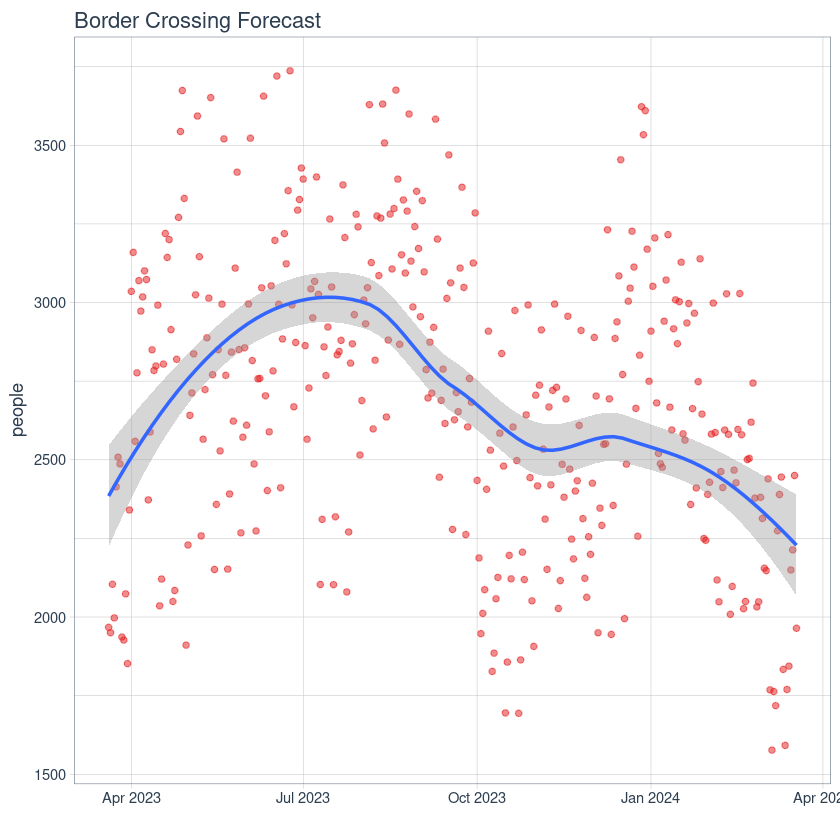

In [21]:
BC %>%
    ggplot(aes(x = date, y = people)) +
    # future data
    geom_point(aes(x = date, y = .pred), data = future_predictions_BC,
               alpha = 0.5, color = palette_light()[[2]]) +
    geom_smooth(aes(x = date, y = .pred), data = future_predictions_BC,
                method = 'loess') + 
    labs(title = "Border Crossing Forecast", x = "") +
    theme_tq()

In [22]:
test_resid_sd <- prediction_BC %>%
    summarize(stdev = sd(people - .pred))

future_predictions_BC <- future_predictions_BC %>%
    mutate(
        lo.95 = .pred - 1.96 * test_resid_sd$stdev,
        lo.80 = .pred - 1.28 * test_resid_sd$stdev,
        hi.80 = .pred + 1.28 * test_resid_sd$stdev,
        hi.95 = .pred + 1.96 * test_resid_sd$stdev
    )

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


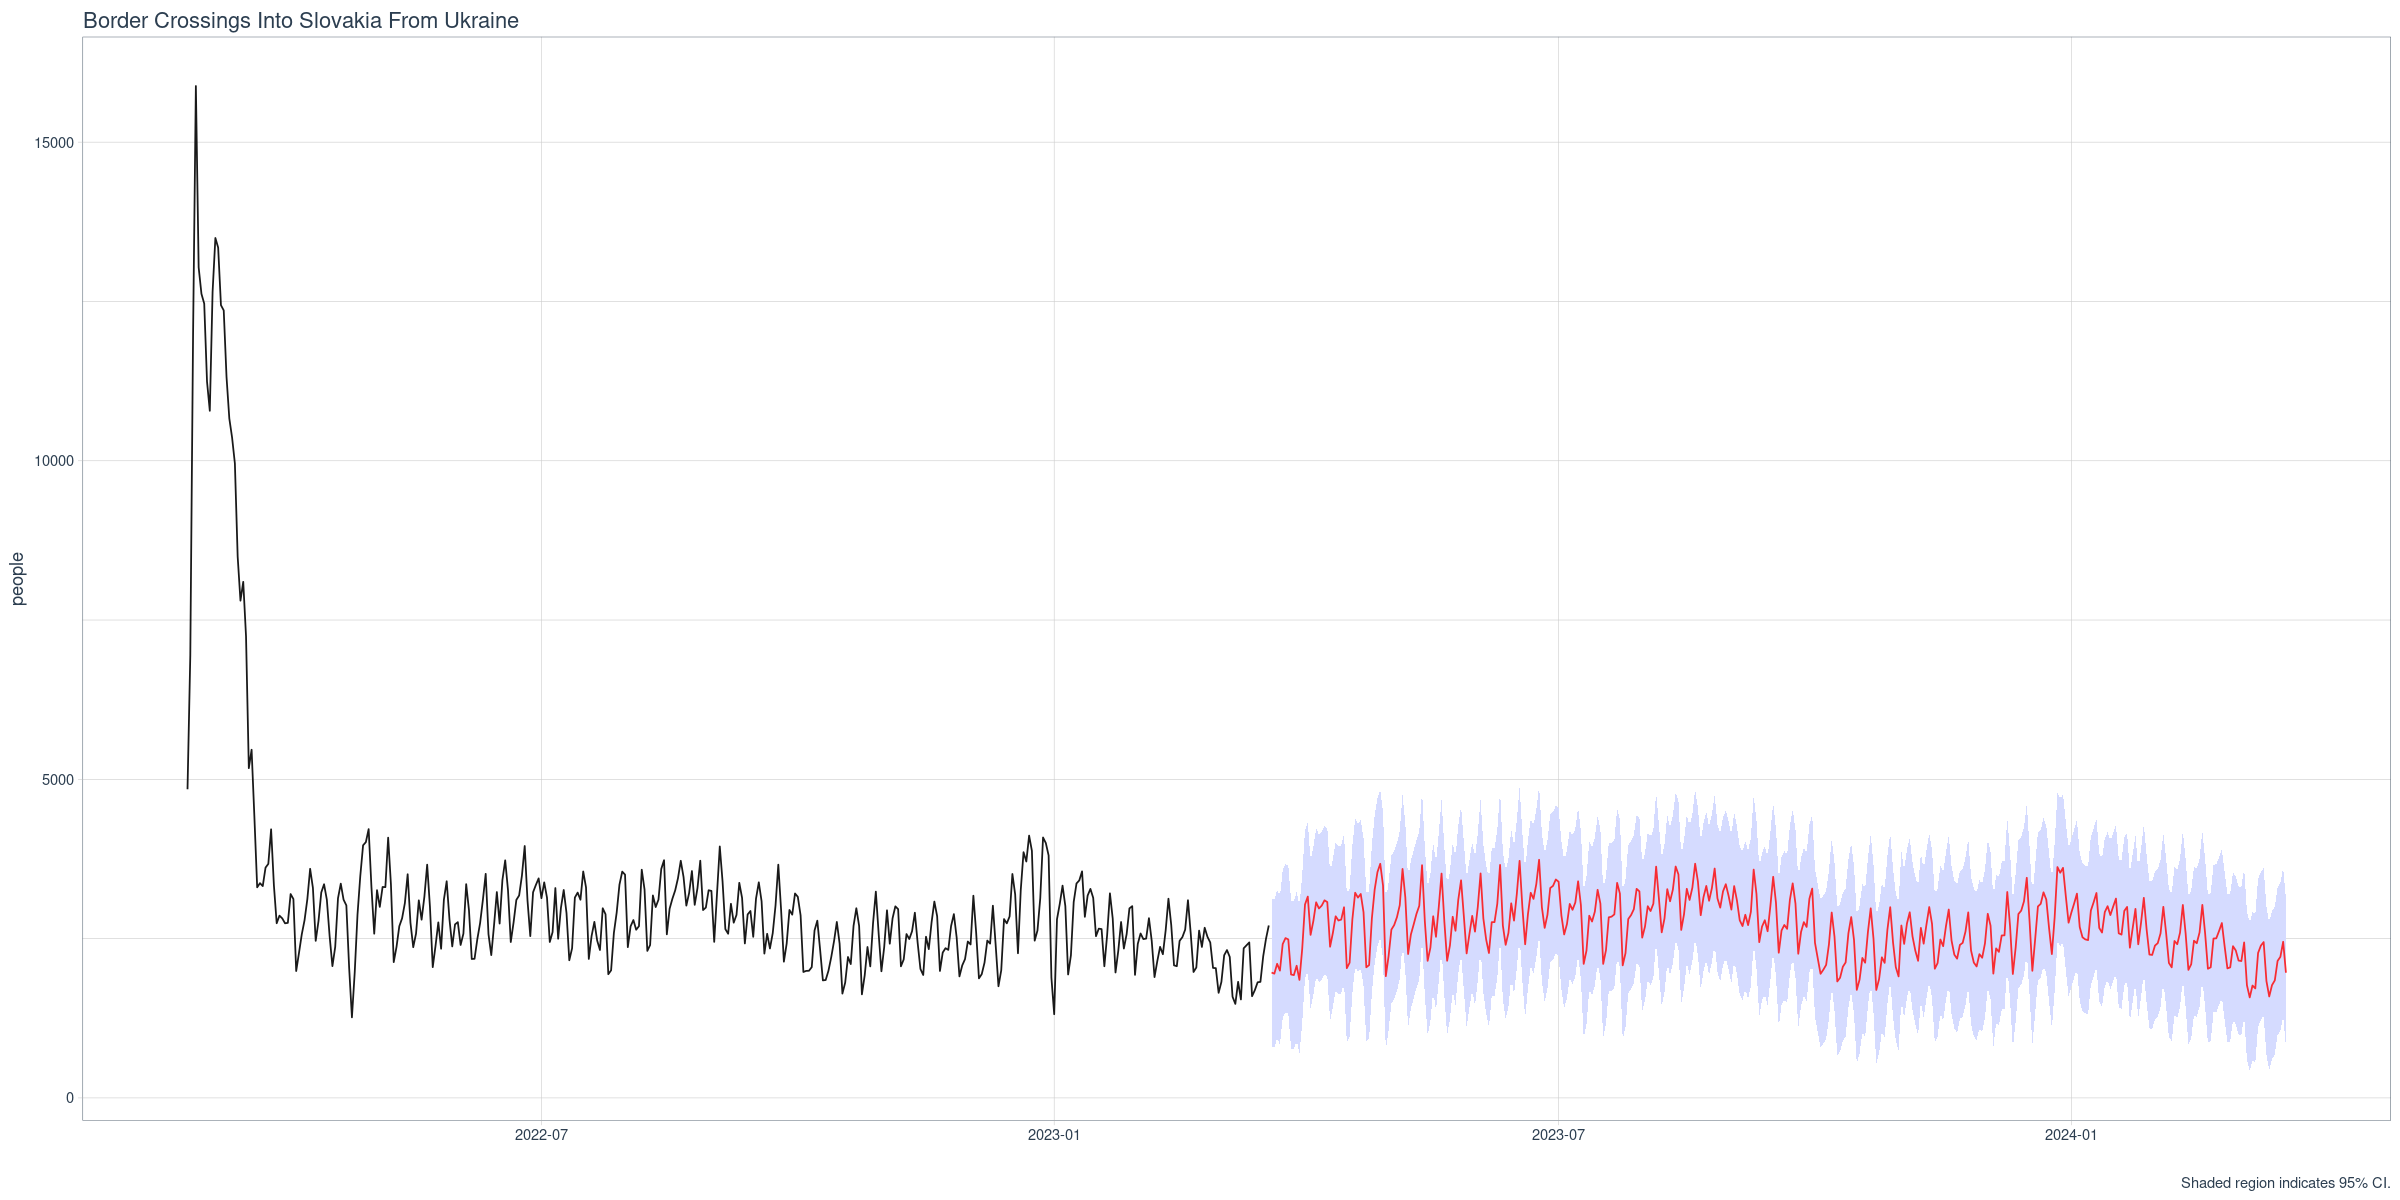

In [23]:
options(repr.plot.width=20, repr.plot.height=10)
BC %>%
    ggplot(aes(x = date, y = people)) +
    geom_point(alpha = 0, color = palette_light()[[1]]) +
    geom_line(alpha = 0.9)+
    geom_ribbon(aes(y = .pred, ymin = lo.95, ymax = hi.95 ), 
                data = future_predictions_BC, 
               fill = "#D5DBFF", color = NA, size = 0) +
   # geom_ribbon(aes(y = .pred, ymin = lo.80, ymax = hi.80,fill = key), 
    #            data = future_predictions_BC,
     #          fill = "#596DD5", color = NA, size = 0, alpha = 0.6) +
    geom_point(aes(x = date, y = .pred), data = future_predictions_BC,
               alpha = 0, color = palette_light()[[2]]) +
     geom_line(aes(x = date, y = .pred), data = future_predictions_BC,
             alpha = 0.8, color = "red") +
   # geom_smooth(aes(x = date, y = .pred), data = future_predictions_BC,
    #            method = 'loess', color = "red", alpha=0.1) + 
    labs(title = "Border Crossings Into Slovakia From Ukraine", x = "", caption='Shaded region indicates 95% CI.') +
    theme_tq()

In [24]:
future_predictions_BC

.pred,date,lo.95,lo.80,hi.80,hi.95
<dbl>,<date>,<dbl>,<dbl>,<dbl>,<dbl>
1967.163,2023-03-20,806.5864,1209.236,2725.091,3127.741
1950.000,2023-03-21,789.4230,1192.072,2707.928,3110.577
2104.215,2023-03-22,943.6382,1346.287,2862.143,3264.792
1997.285,2023-03-23,836.7075,1239.357,2755.212,3157.862
2414.111,2023-03-24,1253.5340,1656.183,3172.039,3574.688
2507.978,2023-03-25,1347.4009,1750.050,3265.906,3668.555
2486.939,2023-03-26,1326.3617,1729.011,3244.867,3647.516
1936.424,2023-03-27,775.8465,1178.496,2694.351,3097.001
1926.755,2023-03-28,766.1782,1168.827,2684.683,3087.332
